# Quick Overview

This chapter gives a quick overview into how to use the package. Detailed explanations can be found in the subchapters of the respective sub-classes.

Import the package and give it an alias, e.g. `h5tbx`.

In [1]:
import h5rdmtoolbox as h5tbx
from h5rdmtoolbox import tutorial

## Select a convention
The file content is controlled by means of a `convention`. This means that specific attributes are required for HDF groups or datasets.

They can be understood as rules, which are validated during usage. To make those rules to become effective, the convention must be imported and enabled. Conventions can be created by the user, too. More on this [here](../conventions/standard_attributes_and_conventions.ipynb).

For now, we select the existing one, which is published on [Zenodo](https://zenodo.org/record/8276716)

In [2]:
cv = h5tbx.convention.from_zenodo('10156750')
cv

Convention("h5rdmtoolbox-tutorial-convention")

From the above representation string of the convention object we can read which attributes are *optional* or **required** for file creation (`__init__`), dataset creation (`create_dataset`) or group creation (`create_group`).

Without enabling the convention, the working with HDF5 files through the `h5rdmtoolbox` is almost (we got a few additional features which make life a bit easier) as by using `h5py`:

In [3]:
with h5tbx.File() as h5:
    h5.dump()

**Now, we enable the convention ...**

In [4]:
h5tbx.use(cv)

using("h5rdmtoolbox-tutorial-convention")

... and get an error, because we are not providing a "data_type":

In [5]:
try:
    with h5tbx.File() as h5:
        pass
except Exception as e:
    print(e)

Convention "h5rdmtoolbox-tutorial-convention" expects standard attribute "data_type" to be provided as an argument during file creation.


## Difference to `h5py` package

The `h5RDMtoolbox` is built upon the `h5py` package. Besides the ability to include conventions, more convenient features are implemented.

### Filename
We could already see, that we did not have to provide a filename when creating a new file. If none is provided, a temporary file is created. Also, `hdf_filename` is provided as an additional property allowing to work with the filename even after the file has been closed *and* to work with `pathlib.Path` objects instead of strings:

In [6]:
with h5tbx.use(None):
    with h5tbx.File() as h5:
        pass
h5.hdf_filename.name  # equal to h5.filename but a pathlib.Path and exists also after the file is closed

'tmp2.hdf'

### Datasets/xarray interface

With the `h5rdmtoolbox` you receive a `xr.DataArray` object instead of a `np.ndarray` when an HDF5 dataset is sliced. Thus, meta information (the attributes of the dataset) is still provided with the data and useful features like plotting is possible.

Let's create some sample data and inspect the data afterward:

In [7]:
import numpy as np

time = np.linspace(0, np.pi/4, 21) # units [s]
signal = np.sin(2*np.pi*3*time) # units [V], physical: [m/s]

with h5tbx.File(contact=h5tbx.__author_orcid__, data_type='experimental') as h5:
    vel_hdf_filename = h5.hdf_filename # store for later use
    
    ds_time = h5.create_dataset(name='time',
                                data=time, 
                                units='s',
                                long_name='measurement time',
                                make_scale=True)
    
    ds_signal = h5.create_dataset(name='vel',
                                  data=signal,
                                  units='m/s',
                                  long_name='air velocity in pipe',
                                  attach_scale=ds_time)

<xarray.DataArray 'vel' (time: 21)>
0.0 0.6745 0.9959 0.7962 0.1797 -0.5308 ... -0.6615 0.01737 0.6872 0.9973 0.7855
Coordinates:
  * time     (time) float64 0.0 0.03927 0.07854 0.1178 ... 0.7069 0.7461 0.7854
Attributes:
    long_name:  air velocity in pipe
    units:      m/s

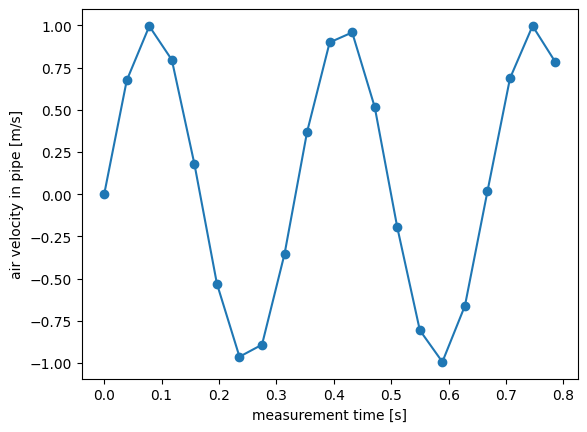

In [8]:
with h5tbx.File(vel_hdf_filename) as h5:
    vel_data = h5['vel'][:]
    vel_data.plot(marker='o')
    
vel_data  # this returns the interactive view of the array and its meta data

### Natural Naming
Until here, we used the conventional way of addressing variables and groups in a dictionary-like style. `h5RDMtoolbox` allows using "natural naming" which means that we can address those objects as if they were attributes. Make sure `h5tbx.config.natural_naming` is set to `True` (the default)

Let's first disable `natural_naming`:

In [9]:
with h5tbx.set_config(natural_naming=False):
    with h5tbx.File(vel_hdf_filename, 'r') as h5:
        try:
            ds = h5.vel[:]
        except Exception as e:
            print(e)

'File' object has no attribute 'vel'


Enable it:

In [10]:
with h5tbx.set_config(natural_naming=True):
    with h5tbx.File(vel_hdf_filename, 'r') as h5:
        ds = h5.vel[:]

## Inspect file content
Often it is necessary to inspect the content of a file (structure, metadata, not the raw data). Calling `dump()` on a group represents the content (dataset, groups and attributes) as a pretty and interactive (!) HTML representation. This is adopted from the `xarray` package. All credits for this idea go there. The representation here avoids showing data, though. Outside an IPython environment, call `sdump()` to get a string representation of the file.

In [11]:
with h5tbx.File(vel_hdf_filename) as h5:
    h5.dump()

In [12]:
with h5tbx.File(vel_hdf_filename) as h5:
    h5.sdump()

a: __h5rdmtoolbox_version__: <class "File" convention: "h5rdmtoolbox-tutorial-convention">
a: contact: <class "File" convention: "h5rdmtoolbox-tutorial-convention">
a: data_type: <class "File" convention: "h5rdmtoolbox-tutorial-convention">
a: standard_name_table: <class "File" convention: "h5rdmtoolbox-tutorial-convention">
time: (21,), dtype: float64
    a: long_name: <HDF5 dataset "time": shape (21,), type "<f8", convention "h5rdmtoolbox-tutorial-convention">
    a: units: <HDF5 dataset "time": shape (21,), type "<f8", convention "h5rdmtoolbox-tutorial-convention">
vel: (21,), dtype: float64
    a: long_name: <HDF5 dataset "vel": shape (21,), type "<f8", convention "h5rdmtoolbox-tutorial-convention">
    a: units: <HDF5 dataset "vel": shape (21,), type "<f8", convention "h5rdmtoolbox-tutorial-convention">


## Databases

The `h5rdmtoolbox` has currently implemented two solutions to use databases with HDF5 file. One solution is mapping metadata into a [mongoDB](https://www.mongodb.com/) database. The other uses the HDF5 file itself as a database and allows querying without any further step.

In this quick tutorial, we use the second solution. More on the topic can be found in the [documentation](https://h5rdmtoolbox.readthedocs.io/en/latest/database/index.html)

Let's find the dataset with name "/vel" (yes, trivial in this case, but just to get an idea). We use `find_one`, because we want to find only one (the first) occurrence:

In [13]:
from h5rdmtoolbox.database import FileDB

In [14]:
res = FileDB(vel_hdf_filename).find_one({'$name': '/vel'})
print(res.name)

/vel


Let's find all (`find`) datasets with the attribute "units" and any value:

In [15]:
res = FileDB(vel_hdf_filename).find({'units': {'$regex': '.*'}})
for r in res:
    print(r)

<LDataset "/vel" in "C:\Users\da4323\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_9\tmp3.hdf" attrs=(units=m/s, long_name=air velocity in pipe)>
<LDataset "/time" in "C:\Users\da4323\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_9\tmp3.hdf" attrs=(long_name=measurement time, units=s)>


## Layouts

Layouts define how a file is expected to be organized, which groups and datasets must exist, which attributes are expected and much more. Layout define expectations and thus help file exchange where multiple users are involved. In the jargon of the toolbox, we call these "specifications".

**Design concept**<br>
The module *layouts* makes use of the database solution for HDF5 files. The idea is, that we should be able to formulate our expectations/specifications in the form of a query. For more detailed information, see [here](https://h5rdmtoolbox.readthedocs.io/en/latest/layouts.html). So we write down our queries, which we expect to find HDF5 objects in a file, when we validate one in the future.

Let's design a simple one, which requires all datasets to have the attribute "units":

In [16]:
from h5rdmtoolbox.layout import Layout

In [17]:
lay = Layout()

spec_all_dataset = lay.add(
    FileDB.find,  # query function
    flt={},
    objfilter='dataset'
)

# The following specification is added to the previous.
# This will apply the query only on results found by the previous query
spec_compression = spec_all_dataset.add(
    FileDB.find_one,
    flt={'units': {'$exists': True}} # attribute "units" exists
)

# we added one specification to the layout. let's check:
lay.specifications  # note, that the second specification is not shown, because it is part of the first one

[LayoutSpecification (kwargs={'flt': {}, 'objfilter': 'dataset'})]

In [18]:
res = lay.validate(vel_hdf_filename)
res.is_valid()

True

The above layout successfully validate the file.

Now, let's add the specification:
- The file must have one dataset named "pressure".
- The exact location within the file does not play a role.
- This specific dataset must have the unit "Pa":
- The shape of the dataset must be equal to (21, )

In [19]:
lay.add(
    FileDB.find_one,  # query function
    flt={'$name': {'$regex': 'pressure'}, 
         '$shape': (21, ),
         'units': 'Pa'},
    objfilter='dataset'
)
lay.specifications

[LayoutSpecification (kwargs={'flt': {}, 'objfilter': 'dataset'}),
 LayoutSpecification (kwargs={'flt': {'$name': {'$regex': 'pressure'}, '$shape': (21,), 'units': 'Pa'}, 'objfilter': 'dataset'})]

The validation now fails:

In [20]:
res = lay.validate(vel_hdf_filename)
res.is_valid()

2023-12-23_11:01:48,852 ERROR    [core.py:130] Applying spec. "LayoutSpecification (kwargs={'flt': {'$name': {'$regex': 'pressure'}, '$shape': (21,), 'units': 'Pa'}, 'objfilter': 'dataset'})" on "C:\Users\da4323\AppData\Local\h5rdmtoolbox\h5rdmtoolbox\tmp\tmp_9\tmp3.hdf" failed.


False

Let's add such a dataset:

In [21]:
with h5tbx.File(vel_hdf_filename, 'r+') as h5:
    h5.create_dataset('subgrp/pressure', shape=(21,), attrs={'units': 'Pa'})

And perform the validation again:

In [22]:
res = lay.validate(vel_hdf_filename)
res.is_valid()

True

Feel free to play with the layout specifications and the HDF5 file content. For sure, knowledge about performing queries with the used database is needed.

## Repositories

Finally, we can publish our data. The toolbox has implemented an interface to [Zenodo](https://zenodo.org/). Using it with the sandbox (testing) environment requires an API TOKEN. For this, please provide the environment variable "ZENODO_SANDBOX_API_TOKEN":

In [23]:
# %set_env ZENODO_SANDBOX_API_TOKEN=<your token>

In [24]:
from h5rdmtoolbox.repository import zenodo
from datetime import datetime

Create a new deposit (repo in the testing environment):

In [25]:
deposit = zenodo.ZenodoSandboxDeposit(None)

Prepare metadata according to the Zenodo API: 

In [26]:
meta = zenodo.metadata.Metadata(
    version="1.0.0",
    title='H5TBX Quick Overview Test',
    description=f'The file created in the quick overview script using the h5rdmtoolbox version {h5tbx.__version__}.',
    creators=[zenodo.metadata.Creator(name="Probst, Matthias",
                                      affiliation="Karlsruhe Institute of Technology, Institute for Thermal Turbomachinery",
                                      orcid="0000-0001-8729-0482")],
    upload_type='dataset',
    access_right='open',
    keywords=['h5rdmtoolbox', 'tutorial', 'repository-test'],
    publication_date=datetime.now(),
)

push metadata to the repository:

In [27]:
deposit.metadata = meta

**Upload the HDF5 file:**<br>
We could upload the HDF5 file alone (using `.upload_file`) or we generate a metadata file as a light-weight version of the potentially large HDF5 file and upload it, too. For this, we need to provide a function, which creates such a metadata file. We choose `hdf2json`:

In [28]:
from h5rdmtoolbox.repository import h5metamapper
deposit.upload_hdf_file(filename=vel_hdf_filename, metamapper=h5metamapper.hdf2json)

In [29]:
deposit.get().json()['links']['html']

'https://sandbox.zenodo.org/deposit/15941'